## generating the dataset
we generate {X, y} from scratch. $X$ is a ndim array of features. $y$ is the corresponding target, and equals XOR of $X_1$ and $X_2$ (ie $y$ is true if either $X_1$ or $X_2$ is true, otherwise it is false). all other features in $X$ is random uniform noise.

## which features should the attention vector attend to?
since $y$ is XOR of $X_1$ and $X_2$, we would expect the attention vector to attend to both $X_1$ and $X_2$. (knowing either $X_1$ and $X_2$ is insufficient.)

moreover, since all other features in $X$ is random noise - and therefore are uninformative features - we would expect attention vector to ignore all other features.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

/Users/vincenttang/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
# generate data from scratch
n_samples = 10000
n_features = 16

X = np.random.uniform(low=-5, high=5, size=(n_samples, n_features))

In [3]:
# set X1 and X2 to either 0 or 1
X[:, 0] = X[:, 0] > 0  # feature 0
X[:, 1] = X[:, 1] > 0  # feature 1

In [4]:
# generate corresponding target y data
y = np.logical_xor(X[:, 0], X[:, 1]) * 1  # y = XOR(X1, X2)

n_classes = 2
y = np.eye(n_classes)[y]  # convert y to one-hot encoding

In [5]:
# attention vector has n_hidden dim, which must equal input ndim since it masks inputs
n_hidden = n_features

In [6]:
# construct feed forward network with attention 
tf.reset_default_graph()

X_ = tf.placeholder(tf.float32, shape=[None, n_features], name="input")
y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name="label")

with tf.variable_scope("parameters"):
    w1 = tf.get_variable("w1", shape=([n_features, n_hidden]), initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b1", shape=([n_hidden]))
    
    w2 = tf.get_variable("w2", shape=([n_hidden, n_classes]), initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b2", shape=([n_classes]))

z1 = tf.matmul(X_, w1) + b1
attention_probs = tf.nn.softmax(z1)  # attention vector
attention_mul = tf.multiply(attention_probs, X_)  # element wise multiplication
z2 = tf.matmul(attention_mul, w2) + b2

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = z2))
op = tf.train.AdamOptimizer(1e-2).minimize(loss)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
n_epochs = 5000
batch_size = 64

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        
        # fetch batches from dataset
        mb_indices = np.random.choice(X.shape[0], batch_size)
        X_train = X[mb_indices]
        y_train = y[mb_indices]
        
        # fit
        _, loss_ = sess.run([op, loss], feed_dict={X_:X_train, y_:y_train})
        
        # inspect
        if epoch % (n_epochs / 10) == 0:
            print("epoch {} loss: {:.3f}".format(epoch, loss_))
    
    # grab attention vector
    attention_vector = sess.run(attention_probs, feed_dict={X_:X, y_:y})

epoch 0 loss: 1.330
epoch 500 loss: 0.679
epoch 1000 loss: 0.701
epoch 1500 loss: 0.676
epoch 2000 loss: 0.545
epoch 2500 loss: 0.162
epoch 3000 loss: 0.017
epoch 3500 loss: 0.010
epoch 4000 loss: 0.005
epoch 4500 loss: 0.003


Text(0.5, 1.0, 'attention vector')

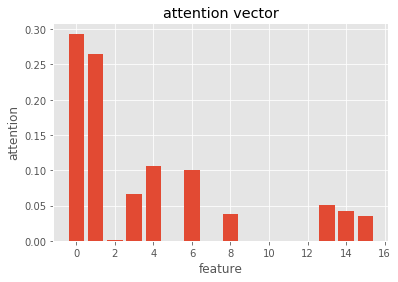

In [8]:
# which features should we attend to?
plt.bar(x = np.arange(n_features), height = np.mean(attention_vector, axis=0))
plt.xlabel("feature")
plt.ylabel("attention")
plt.title("attention vector")